<a href="https://colab.research.google.com/github/tushar-marine/colon_cancer/blob/main/fusion_model_VGG16_ResNet50V2_colon_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adding Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Moving to working directory** 

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/thesis')

#**Importing required libraries**

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import misc

#**Data Preprocessing**

##**Loading the data**

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/thesis/dataset/"
num_classes = 8

x = []
y = []
for category in os.listdir(data_path):
    for image in os.listdir(data_path + category):
        if image.endswith(".tif"):
            arr = cv2.imread(data_path + category + '/' + image)
            x.append(arr)
            y.append(category)

In [ ]:
class_names = ['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']

##**Encoding data into a numerical representation**##

In [ ]:
input_shape = (150, 150, 3)
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
y = keras.utils.to_categorical(encoded_y, num_classes)

##**Shuffling the data**##

In [ ]:
x, y = shuffle(x, y, random_state=1)

##**Splitting the dataset for trainng and testing**##

In [ ]:
# 90% for training and 10% for testing
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)

##**Normalisation by scaling all pixel intensities**##

In [ ]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (4500, 150, 150, 3)
4500 train samples
500 test samples


#**Building models**

##**Model-1**

In [ ]:
from tensorflow.keras.applications import ResNet50V2

model_1 = ResNet50V2(weights="imagenet", input_shape=input_shape, include_top=False)

# Freeze the first 20 layers
for layer in model_1.layers[:20]:
    layer.trainable = False

# Adding Global Average Pooling (GAP) layer to the Xception
x_model_1 = model_1.output
x_model_1 = tf.keras.layers.GlobalAveragePooling2D()(x_model_1)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
len(model_1.layers)

190

##**Model-2**

In [ ]:
from tensorflow.keras.applications import VGG16

model_2 = VGG16(weights="imagenet", input_shape=input_shape, include_top=False)

# Freeze all layers
model_2.trainable = False

# Adding Global Average Pooling (GAP) layer to the ResNet50V2
x_model_2 = model_2.output
x_model_2 = tf.keras.layers.GlobalAveragePooling2D()(x_model_2)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
len(model_2.layers)

19

##**Fusion Model**##

In [ ]:
# concatenation of Model-1 & Model-2
x_combined = tf.keras.layers.concatenate([x_model_2, x_model_1])

# Adding dropout (for regularization), SoftMax, Adam as optimizer and categorical_crossentropy as loss function
x_combined = tf.keras.layers.Dense(256, activation="relu")(x_combined)
x_combined = tf.keras.layers.Dropout(0.6)(x_combined)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x_combined)   
fusion_model = tf.keras.models.Model( inputs = [model_1.input, model_2.input] , outputs = predictions)
fusion_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
history_record = fusion_model.fit(x=[x_train, x_train], y = y_train, 
                           batch_size=32,
                           epochs=10, 
                           verbose=1,
                           validation_data=([x_test, x_test], y_test))

Epoch 1/10
141/141 [==============================] - 2435s 17s/step - loss: 0.8441 - accuracy: 0.7347 - val_loss: 33.6032 - val_accuracy: 0.3520
Epoch 2/10
141/141 [==============================] - 2419s 17s/step - loss: 0.4990 - accuracy: 0.8398 - val_loss: 0.6535 - val_accuracy: 0.8200
Epoch 3/10
141/141 [==============================] - 2424s 17s/step - loss: 0.4304 - accuracy: 0.8571 - val_loss: 5.5215 - val_accuracy: 0.5700
Epoch 4/10
141/141 [==============================] - 2420s 17s/step - loss: 0.3296 - accuracy: 0.8922 - val_loss: 0.3558 - val_accuracy: 0.8740
Epoch 5/10
141/141 [==============================] - 2421s 17s/step - loss: 0.2804 - accuracy: 0.9022 - val_loss: 0.4242 - val_accuracy: 0.8480
Epoch 6/10
141/141 [==============================] - 2426s 17s/step - loss: 0.2548 - accuracy: 0.9140 - val_loss: 0.2847 - val_accuracy: 0.9060
Epoch 7/10
141/141 [==============================] - 2442s 17s/step - loss: 0.2163 - accuracy: 0.9311 - val_loss: 0.3174 - val_a

##**Fine-tuning Model**##

In [ ]:
# Unfreeze the entire base model
model_1.trainable = True
model_2.trainable = True

# Freeze all layers except the last 10 layers for both models
for layer in model_2.layers[:-10]:
  layer.trainable = False

for layer in model_2.layers[:-10]:
  layer.trainable = False

In [ ]:
fusion_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(0.00001),
                     metrics = ["accuracy"])
history_fine_tuning = fusion_model.fit(x=[x_train, x_train], y = y_train, 
                           batch_size=32,
                           epochs=10, 
                           verbose=1,
                           validation_data=([x_test, x_test], y_test))

Epoch 1/10
141/141 [==============================] - 3746s 27s/step - loss: 0.1302 - accuracy: 0.9544 - val_loss: 0.2519 - val_accuracy: 0.9160
Epoch 2/10
141/141 [==============================] - 3748s 27s/step - loss: 0.0966 - accuracy: 0.9693 - val_loss: 0.2301 - val_accuracy: 0.9220
Epoch 3/10
141/141 [==============================] - 3745s 27s/step - loss: 0.0837 - accuracy: 0.9751 - val_loss: 0.2006 - val_accuracy: 0.9360
Epoch 4/10
141/141 [==============================] - 3757s 27s/step - loss: 0.0489 - accuracy: 0.9869 - val_loss: 0.1894 - val_accuracy: 0.9400
Epoch 5/10
141/141 [==============================] - 3753s 27s/step - loss: 0.0462 - accuracy: 0.9884 - val_loss: 0.2415 - val_accuracy: 0.9300
Epoch 6/10
141/141 [==============================] - 3733s 26s/step - loss: 0.0446 - accuracy: 0.9882 - val_loss: 0.2115 - val_accuracy: 0.9360
Epoch 7/10
141/141 [==============================] - 3719s 26s/step - loss: 0.0399 - accuracy: 0.9909 - val_loss: 0.2005 - val_ac

# **Testing the Model**

**Model plotting with details by layers**

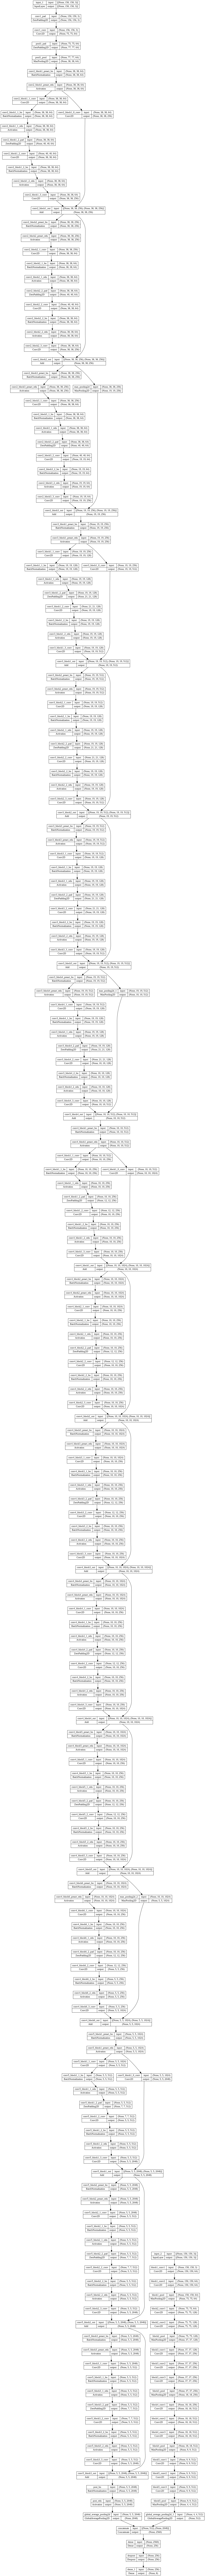

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(fusion_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Test Score**

In [ ]:
test_score = fusion_model.evaluate(x=[x_test, x_test], y = y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 0.20939487218856812
Test accuracy: 0.9459999799728394


**Model Accuracy Curve** 

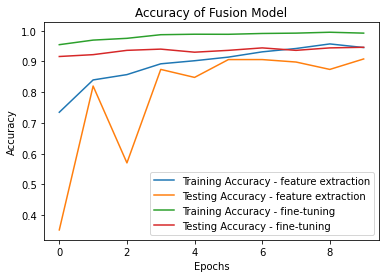

In [ ]:
loss_fn = history_record.history['loss']
val_loss_fn = history_record.history['val_loss']
accuracy_fn = history_record.history['accuracy']
val_accuracy_fn = history_record.history['val_accuracy']
epochs = range(len(history_record.history['loss']))

loss_tuned = history_fine_tuning.history['loss']
val_loss_tuned = history_fine_tuning.history['val_loss']
accuracy_tuned = history_fine_tuning.history['accuracy']
val_accuracy_tuned = history_fine_tuning.history['val_accuracy']

# Plotting accuracy curve
plt.figure()
plt.plot(epochs, accuracy_fn, label='Training Accuracy - feature extraction')
plt.plot(epochs, val_accuracy_fn, label='Testing Accuracy - feature extraction')
plt.plot(epochs, accuracy_tuned, label='Training Accuracy - fine-tuning')
plt.plot(epochs, val_accuracy_tuned, label='Testing Accuracy - fine-tuning')
plt.title('Accuracy of Fusion Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

**Model Loss Curve**

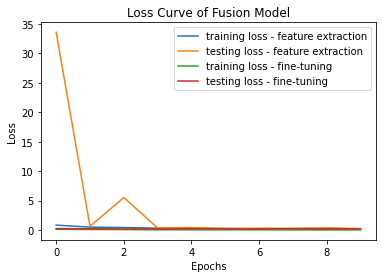

In [ ]:
# Plotting loss curve
plt.figure()
plt.plot(epochs, loss_fn, label='training loss - feature extraction')
plt.plot(epochs, val_loss_fn, label='testing loss - feature extraction')
plt.plot(epochs, loss_tuned, label='training loss - fine-tuning')
plt.plot(epochs, val_loss_tuned, label='testing loss - fine-tuning')
plt.title('Loss Curve of Fusion Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

**Confusion Matrix**

In [ ]:
# Model prediction for test data
pred = fusion_model.predict(x=[x_test, x_test])

# Match the prediction class to the highest prediction probability
y_pred = [pred[i].argmax() for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Extract the truth ground label and match to class_names 
y_true = []
for i in range(len(y_test)):
    for y in range(8):
        if y_test[i][y]==1:
            y_true.append(y)
            break

y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

16/16 [==============================] - 145s 9s/step


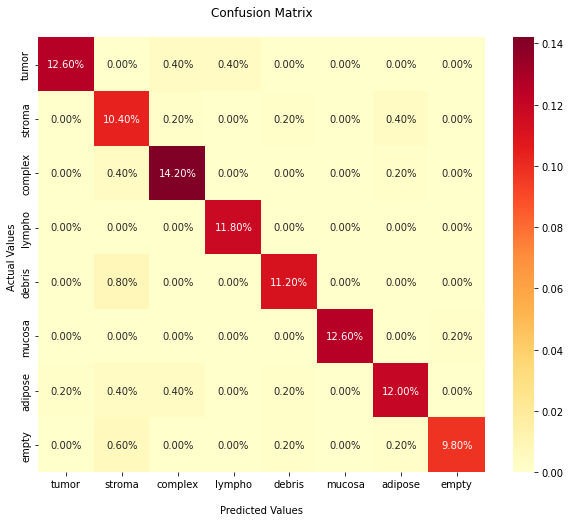

In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

**Classification Report**

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

     adipose      0.938     0.909     0.923        66
     complex      0.934     0.959     0.947        74
      debris      0.949     0.933     0.941        60
       empty      0.980     0.907     0.942        54
      lympho      0.967     1.000     0.983        59
      mucosa      1.000     0.984     0.992        64
      stroma      0.825     0.929     0.874        56
       tumor      0.984     0.940     0.962        67

    accuracy                          0.946       500
   macro avg      0.947     0.945     0.946       500
weighted avg      0.948     0.946     0.946       500

